<a href="https://colab.research.google.com/github/arpitpatelsitapur/my-py-torch-journey/blob/main/PyTorch_Transfer_Learning_VGG16_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Transfer Learning with VGG16**
- using Pretrained model and training it's classifier on our small dataset


<img src="https://drive.google.com/uc?export=view&id=1SOdSz_AcNo6UF7ujGAjuNgxP5Rfw0rZK" alt="VGG16 Architecture"  width="190">

In [ ]:
!pip install torchinfo

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


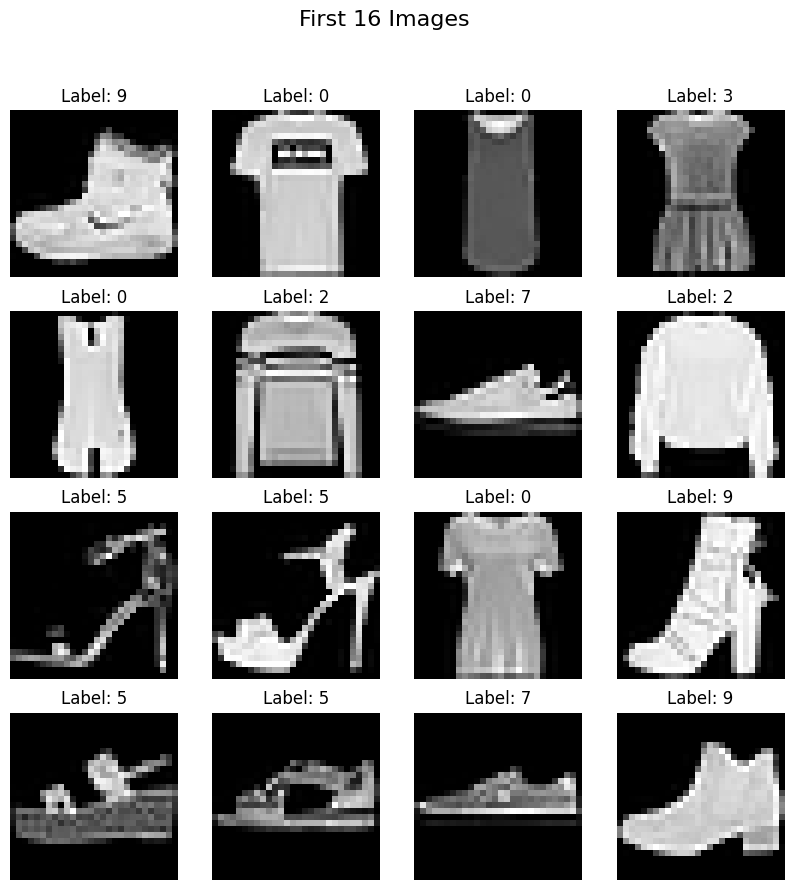

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchinfo import summary
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader
from keras import datasets
torch.manual_seed(7)

# check gpu availability
if torch.cuda.is_available():
  device=torch.device("cuda")
else:
  device=torch.device("cpu")

# load dataset
(X_train, y_train), (X_test, y_test) =datasets.fashion_mnist.load_data()


# Reshape the arrays to be 2-dimensional
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
y_train = y_train.reshape(y_train.shape[0], -1)
y_test = y_test.reshape(y_test.shape[0], -1)

# convert into tensors - these are not used in the CustomDataset, so we can remove them or keep them for other purposes. Keeping them for now.
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.long)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.long)

# Create a 4x4 grid of images
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
fig.suptitle("First 16 Images", fontsize=16)

# Plot the first 16 images from the dataset
for i, ax in enumerate(axes.flat):
    ax.imshow(X_train[i].reshape(28, 28), cmap='gray') # Use the numpy array directly for plotting
    ax.set_title(f"Label: {y_train[i][0]}") # Access label from numpy array
    ax.axis('off')

# Show the plot
plt.show()

In [ ]:
# transformations
from torchvision.transforms import transforms

custom_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
from PIL import Image
import numpy as np

class CustomDataset(Dataset):

  def __init__(self, features, labels, transform):
    self.features = features
    self.labels = labels
    self.transform = transform

  def __len__(self):
    return len(self.features)

  def __getitem__(self, index):

    # resize to (28, 28)
    image = self.features[index].reshape(28,28)

    # change datatype to np.uint8
    image = image.astype(np.uint8)

    # change black&white to color -> (H,W,C) -> (C,H,W)
    image = np.stack([image]*3, axis=-1)

    # convert array to PIL image
    image = Image.fromarray(image)

    # apply transforms
    image = self.transform(image)

    # return
    return image, torch.tensor(self.labels[index], dtype=torch.long)

In [ ]:
train_dataset = CustomDataset(X_train, y_train, transform=custom_transform)
test_dataset = CustomDataset(X_test, y_test, transform=custom_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True)

In [ ]:
# fetch the pretrained model

import torchvision.models as models

vgg16 = models.vgg16(pretrained=True)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:06<00:00, 92.1MB/s]


In [ ]:
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
for param in vgg16.features.parameters():
  param.requires_grad=False

In [ ]:
vgg16.classifier = nn.Sequential(
    nn.Linear(25088, 1024),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 10)
)

vgg16 = vgg16.to(device)
learning_rate = 0.0001
epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16.classifier.parameters(), lr=learning_rate)

# training loop

for epoch in range(epochs):
  total_epoch_loss = 0
  for batch_features, batch_labels in train_loader:
    # move data to gpu
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device).squeeze()
    # forward pass
    outputs = vgg16(batch_features)
    # calculate loss
    loss = criterion(outputs, batch_labels)
    # back pass
    optimizer.zero_grad()
    loss.backward()
    # update grads
    optimizer.step()
    total_epoch_loss = total_epoch_loss + loss.item()
    # break # Removing the break to train for the whole epoch

  avg_loss = total_epoch_loss/len(train_loader)
  print(f'Epoch: {epoch + 1} , Loss: {avg_loss}')

# evaluation on training data
total = 0
correct = 0

with torch.no_grad():
  for batch_features, batch_labels in train_loader:
    # move data to gpu
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device).squeeze()
    outputs = vgg16(batch_features)
    _, predicted = torch.max(outputs, 1)
    total = total + batch_labels.shape[0]
    correct = correct + (predicted == batch_labels).sum().item()
print(f'Training Accuracy: {correct/total}')


vgg16.eval()
# evaluation on test data
total = 0
correct = 0
with torch.no_grad():
  for batch_features, batch_labels in test_loader:
    # move data to gpu
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device).squeeze()
    outputs = vgg16(batch_features)
    _, predicted = torch.max(outputs, 1)
    total = total + batch_labels.shape[0]
    correct = correct + (predicted == batch_labels).sum().item()
print(f'Test Accuracy: {correct/total}')

Epoch: 1 , Loss: 0.34006359164118766
Epoch: 2 , Loss: 0.2094917753522595
Epoch: 3 , Loss: 0.1644457642344137
Epoch: 4 , Loss: 0.1281575264941901
Epoch: 5 , Loss: 0.10362281618164852
Epoch: 6 , Loss: 0.08356503398350129
Epoch: 7 , Loss: 0.06793888370180891
Epoch: 8 , Loss: 0.05656052796602598
Epoch: 9 , Loss: 0.04984420206093443
Epoch: 10 , Loss: 0.04263365052963684
Training Accuracy: 0.9883166666666666
Test Accuracy: 0.9272
